In [1]:
import os
import sys
sys.path.append("../")
from Attune_function6_22 import *
from bgi.metrics.metrics import *
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
#Select an available GPU to run on a multi-GPU computer or you can run it directly on the CPU without executing this cell
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# preprocess

In [2]:
# input
rna_raw = sc.read('./data/ad_rna.h5ad')
atac_raw = sc.read('./data/ad_atac.h5ad')

In [5]:
# Only 22 chromatins are remained 
chrs = [
    'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
    'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
    'chr21', 'chr22']
chr_list = atac_raw.var['chr'].tolist()
chr_differ_list = list(set(chr_list).difference(set(chrs)))
for i in chr_differ_list:
    atac_raw = atac_raw[:,atac_raw.var['chr']!=i]
atac_raw.write_h5ad('./data/ad_atac_wox.h5ad')

In [6]:
# filter
sc.pp.filter_cells(atac_raw, min_genes=0)
sc.pp.filter_genes(atac_raw, min_cells=0)
thres = int(atac_raw.shape[0]*0.05)
atac_raw_filter = atac_raw[:, atac_raw.var['n_cells']>thres]
atac_raw_filter.write_h5ad('./data/atac_wox_filter.h5ad')

Trying to set attribute `.obs` of view, copying.


In [7]:
# hvg
rna_raw_hvg = preprocessing_rna(rna_raw,n_top_features=2000,is_hvg=True,batch_key=None)
rna_raw_hvg.write_h5ad('./data/rna_hvg.h5ad')

Processed dataset shape: (11909, 2000)


# make TF-record

In [10]:
# make tfrecord
save_path = './tfrecord/RNA/'
sim_tf_path = concerto_make_tfrecord(rna_raw_hvg, tf_path = save_path, batch_col_name=None)
save_path = './tfrecord/ATAC/'
sim_tf_path = concerto_make_tfrecord(atac_raw_filter, tf_path = save_path, batch_col_name=None)

AnnData object with n_obs × n_vars = 11909 × 2000
    obs: 'n_genes', 'celltype', 'batch_'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
counter: 1000 shape: (2000,), batch: 0
counter: 2000 shape: (2000,), batch: 0
counter: 3000 shape: (2000,), batch: 0
counter: 4000 shape: (2000,), batch: 0
counter: 5000 shape: (2000,), batch: 0
counter: 6000 shape: (2000,), batch: 0
counter: 7000 shape: (2000,), batch: 0
counter: 8000 shape: (2000,), batch: 0
counter: 9000 shape: (2000,), batch: 0
counter: 10000 shape: (2000,), batch: 0
counter: 11000 shape: (2000,), batch: 0


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 11909 × 28708
    obs: 'celltype', 'n_genes', 'batch_'
    var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end', 'n_cells'
counter: 1000 shape: (28708,), batch: 0
counter: 2000 shape: (28708,), batch: 0
counter: 3000 shape: (28708,), batch: 0
counter: 4000 shape: (28708,), batch: 0
counter: 5000 shape: (28708,), batch: 0
counter: 6000 shape: (28708,), batch: 0
counter: 7000 shape: (28708,), batch: 0
counter: 8000 shape: (28708,), batch: 0
counter: 9000 shape: (28708,), batch: 0
counter: 10000 shape: (28708,), batch: 0
counter: 11000 shape: (28708,), batch: 0


# train

In [11]:
random.seed(0)
RNA_tf_path = f'./tfrecord/RNA/'
ATAC_tf_path = f'./tfrecord/ATAC/'
dict_ = {'batch_size': 128, 'epoch_pretrain': 20, 'lr': 1e-4, 'drop_rate': 0.1,'temperature':0.1}
weight_path = f'./weight/pretrain/'
attune_pretrain(RNA_tf_path,ATAC_tf_path, weight_path,super_parameters = dict_)


./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
Epoch1, step5, total loss:13.367
Epoch1, step10, total loss:12.433
Epoch1, step15, total loss:11.969
Epoch1, step20, total loss:11.658
Epoch1, step25, total loss:11.434
Epoch1, step30, total loss:11.251
Epoch1, step35, total loss:11.102
Epoch1, step40, total loss:10.971
Epoch1, step45, total loss:10.841
Epoch1, step50, total loss:10.722
Epoch1, step55, total loss:10.611
Epoch1, step60, total loss:10.515
Epoch1, step65, total loss:10.419
Epoch1, step70, total loss:10.331
Epoch1, step75, total loss:10.251
Epoch1, step80, total loss:10.180
Epoch1, step85, total loss:10.105
Epoch1, step90, total loss:10.032
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
Epoch2, step5, total loss:8.706
Epoch2, step10, total loss:8.661
Epoch2, step15, total loss:8.594
Epoch2, step20, total loss:8.557
Epoch2, step25, total loss:8.529
Epoch2, step30, total loss:8.494
Epoch2, step35, total loss:8.461
Epoch2, step40, total loss:8.434
Epoch2, 

Epoch13, step45, total loss:2.610
Epoch13, step50, total loss:2.596
Epoch13, step55, total loss:2.592
Epoch13, step60, total loss:2.604
Epoch13, step65, total loss:2.607
Epoch13, step70, total loss:2.616
Epoch13, step75, total loss:2.614
Epoch13, step80, total loss:2.611
Epoch13, step85, total loss:2.602
Epoch13, step90, total loss:2.593
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
Epoch14, step5, total loss:2.401
Epoch14, step10, total loss:2.418
Epoch14, step15, total loss:2.428
Epoch14, step20, total loss:2.428
Epoch14, step25, total loss:2.435
Epoch14, step30, total loss:2.442
Epoch14, step35, total loss:2.450
Epoch14, step40, total loss:2.452
Epoch14, step45, total loss:2.453
Epoch14, step50, total loss:2.445
Epoch14, step55, total loss:2.445
Epoch14, step60, total loss:2.457
Epoch14, step65, total loss:2.454
Epoch14, step70, total loss:2.457
Epoch14, step75, total loss:2.457
Epoch14, step80, total loss:2.454
Epoch14, step85, total loss:2.448
Epoch14, step90, total l

# test

In [12]:
for i in range(20):
    saved_result_path = f'./result/'
    if not os.path.exists(saved_result_path):
        os.makedirs(saved_result_path)
    RNA_tf_path = f'./tfrecord/RNA/'
    ATAC_tf_path = f'./tfrecord/ATAC/'
    dict_ = {'batch_size': 128, 'epoch_pretrain': i+1, 'lr': 1e-4, 'drop_rate': 0.1}
    weight_path = f'./weight/pretrain/'
    cell_embed_RNA_all, cell_embed_ATAC_all, RNA_id_all = attune_test(RNA_tf_path = RNA_tf_path, ATAC_tf_path = ATAC_tf_path, 
                                                                      saved_weight_path_pretrain = weight_path, n_cells_for_sample = None,
                                                                      super_parameters = dict_)
    f = {'cell_embed_RNA': cell_embed_RNA_all,
         'cell_embed_ATAC': cell_embed_ATAC_all,
         'RNA_id': RNA_id_all,}
    ep = dict_['epoch_pretrain']
    np.savez_compressed(saved_result_path + f'./result_ep{ep}.npz', **f)

load saved weight
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
feature_len: 50000
all_samples num:128
all_samples num:256
all_samples num:384
all_samples num:512
all_samples num:640
all_samples num:768
all_samples num:896
all_samples num:1024
all_samples num:1152
all_samples num:1280
all_samples num:1408
all_samples num:1536
all_samples num:1664
all_samples num:1792
all_samples num:1920
all_samples num:2048
all_samples num:2176
all_samples num:2304
all_samples num:2432
all_samples num:2560
all_samples num:2688
all_samples num:2816
all_samples num:2944
all_samples num:3072
all_samples num:3200
all_samples num:3328
all_samples num:3456
all_samples num:3584
all_samples num:3712
all_samples num:3840
all_samples num:3968
all_samples num:4096
all_samples num:4224
all_samples num:4352
all_samples num:4480
all_samples num:4608
all_samples num:4736
all_samples num:4864
all_samples num:4992
all_samples num:5120
all_samples num:5248
all_samples num:5376
all_samples num:5504
all_samp

all_samples num:11904
load saved weight
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
feature_len: 50000
all_samples num:128
all_samples num:256
all_samples num:384
all_samples num:512
all_samples num:640
all_samples num:768
all_samples num:896
all_samples num:1024
all_samples num:1152
all_samples num:1280
all_samples num:1408
all_samples num:1536
all_samples num:1664
all_samples num:1792
all_samples num:1920
all_samples num:2048
all_samples num:2176
all_samples num:2304
all_samples num:2432
all_samples num:2560
all_samples num:2688
all_samples num:2816
all_samples num:2944
all_samples num:3072
all_samples num:3200
all_samples num:3328
all_samples num:3456
all_samples num:3584
all_samples num:3712
all_samples num:3840
all_samples num:3968
all_samples num:4096
all_samples num:4224
all_samples num:4352
all_samples num:4480
all_samples num:4608
all_samples num:4736
all_samples num:4864
all_samples num:4992
all_samples num:5120
all_samples num:5248
all_samples num:5376
all_sam

all_samples num:11776
all_samples num:11904
load saved weight
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
feature_len: 50000
all_samples num:128
all_samples num:256
all_samples num:384
all_samples num:512
all_samples num:640
all_samples num:768
all_samples num:896
all_samples num:1024
all_samples num:1152
all_samples num:1280
all_samples num:1408
all_samples num:1536
all_samples num:1664
all_samples num:1792
all_samples num:1920
all_samples num:2048
all_samples num:2176
all_samples num:2304
all_samples num:2432
all_samples num:2560
all_samples num:2688
all_samples num:2816
all_samples num:2944
all_samples num:3072
all_samples num:3200
all_samples num:3328
all_samples num:3456
all_samples num:3584
all_samples num:3712
all_samples num:3840
all_samples num:3968
all_samples num:4096
all_samples num:4224
all_samples num:4352
all_samples num:4480
all_samples num:4608
all_samples num:4736
all_samples num:4864
all_samples num:4992
all_samples num:5120
all_samples num:5248
all_sa

all_samples num:11648
all_samples num:11776
all_samples num:11904
load saved weight
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
feature_len: 50000
all_samples num:128
all_samples num:256
all_samples num:384
all_samples num:512
all_samples num:640
all_samples num:768
all_samples num:896
all_samples num:1024
all_samples num:1152
all_samples num:1280
all_samples num:1408
all_samples num:1536
all_samples num:1664
all_samples num:1792
all_samples num:1920
all_samples num:2048
all_samples num:2176
all_samples num:2304
all_samples num:2432
all_samples num:2560
all_samples num:2688
all_samples num:2816
all_samples num:2944
all_samples num:3072
all_samples num:3200
all_samples num:3328
all_samples num:3456
all_samples num:3584
all_samples num:3712
all_samples num:3840
all_samples num:3968
all_samples num:4096
all_samples num:4224
all_samples num:4352
all_samples num:4480
all_samples num:4608
all_samples num:4736
all_samples num:4864
all_samples num:4992
all_samples num:5120
all_s

all_samples num:11520
all_samples num:11648
all_samples num:11776
all_samples num:11904
load saved weight
./tfrecord/RNA/tf_0.tfrecord
./tfrecord/ATAC/tf_0.tfrecord
feature_len: 50000
all_samples num:128
all_samples num:256
all_samples num:384
all_samples num:512
all_samples num:640
all_samples num:768
all_samples num:896
all_samples num:1024
all_samples num:1152
all_samples num:1280
all_samples num:1408
all_samples num:1536
all_samples num:1664
all_samples num:1792
all_samples num:1920
all_samples num:2048
all_samples num:2176
all_samples num:2304
all_samples num:2432
all_samples num:2560
all_samples num:2688
all_samples num:2816
all_samples num:2944
all_samples num:3072
all_samples num:3200
all_samples num:3328
all_samples num:3456
all_samples num:3584
all_samples num:3712
all_samples num:3840
all_samples num:3968
all_samples num:4096
all_samples num:4224
all_samples num:4352
all_samples num:4480
all_samples num:4608
all_samples num:4736
all_samples num:4864
all_samples num:4992
all_

all_samples num:11392
all_samples num:11520
all_samples num:11648
all_samples num:11776
all_samples num:11904


# Plot cell embeddings

In [3]:
adata_rna = sc.read('./data/rna_hvg.h5ad')
adata_atac = sc.read('./data/atac_wox_filter.h5ad')

In [4]:
f = np.load(f'./result/result_ep1.npz')
cell_embed_RNA = f['cell_embed_RNA']
cell_embed_ATAC = f['cell_embed_ATAC']
RNA_id = f['RNA_id']
adata_rna_1 =adata_rna[RNA_id]
adata_atac_1 =adata_atac[RNA_id]

... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


... storing 'celltype' as categorical
... storing 'batch' as categorical


plot finished


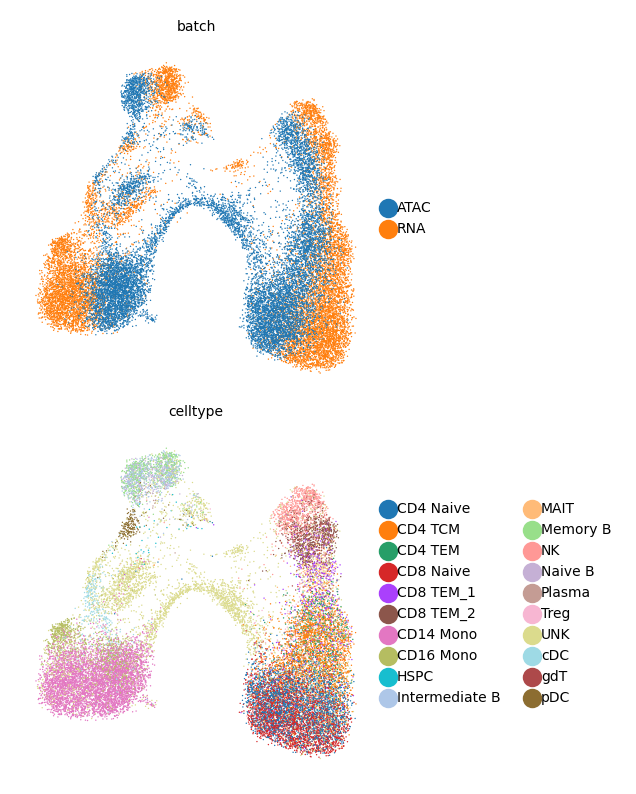

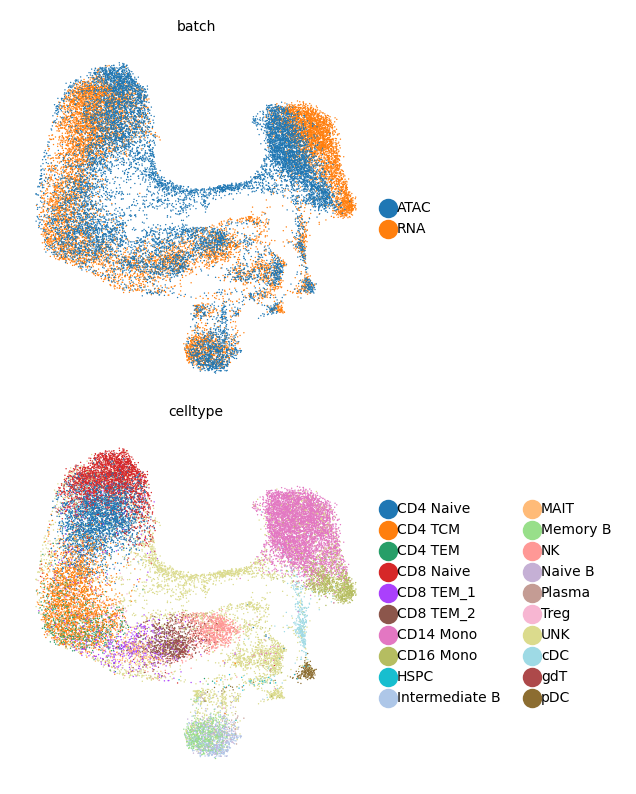

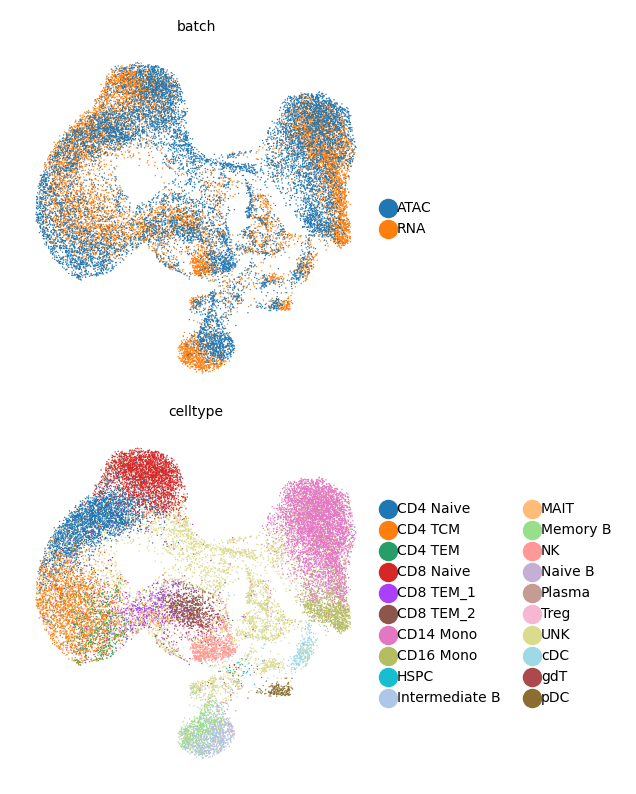

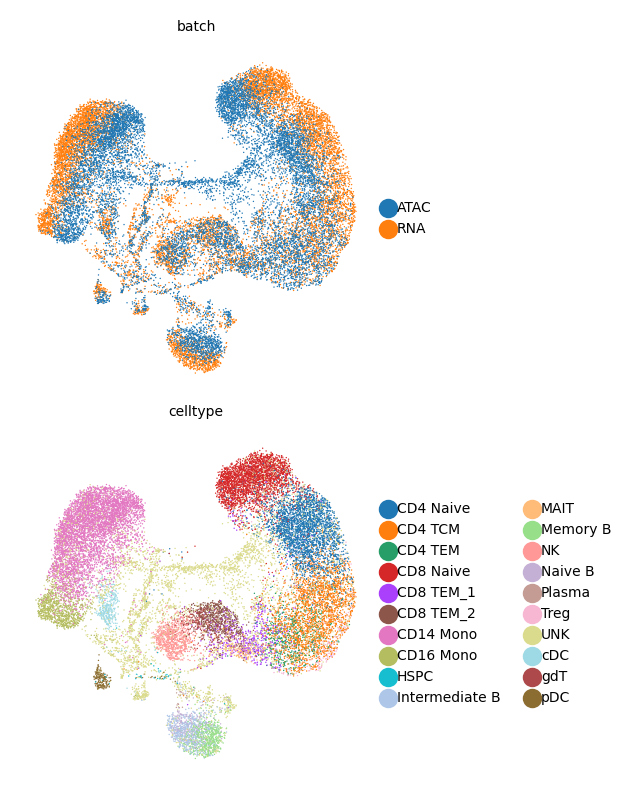

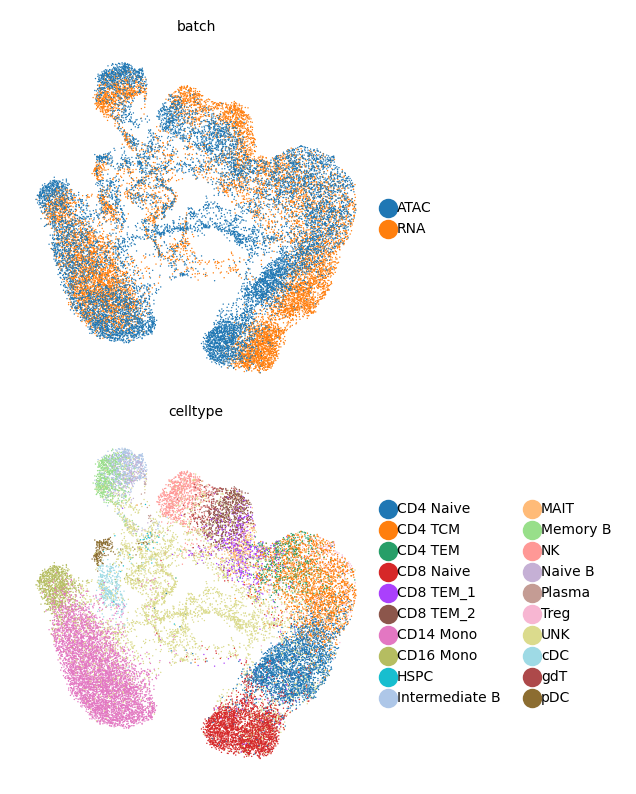

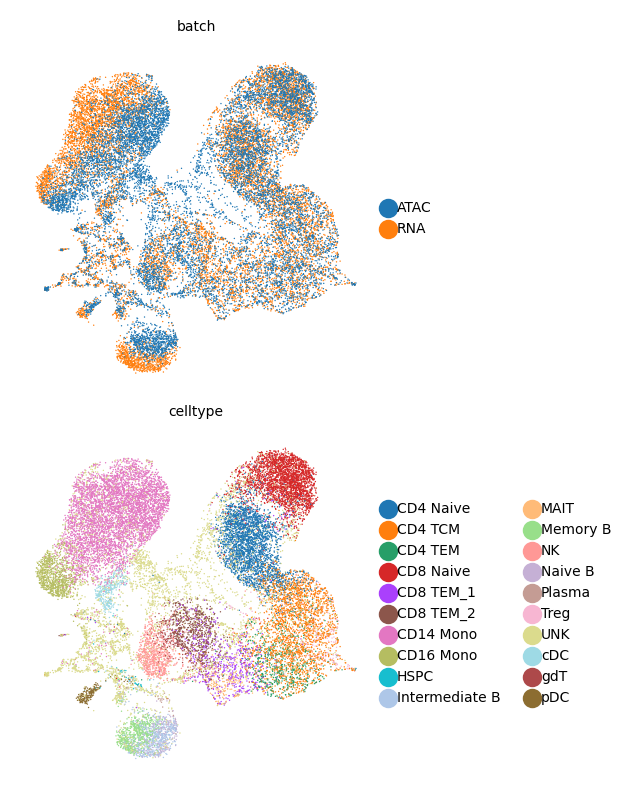

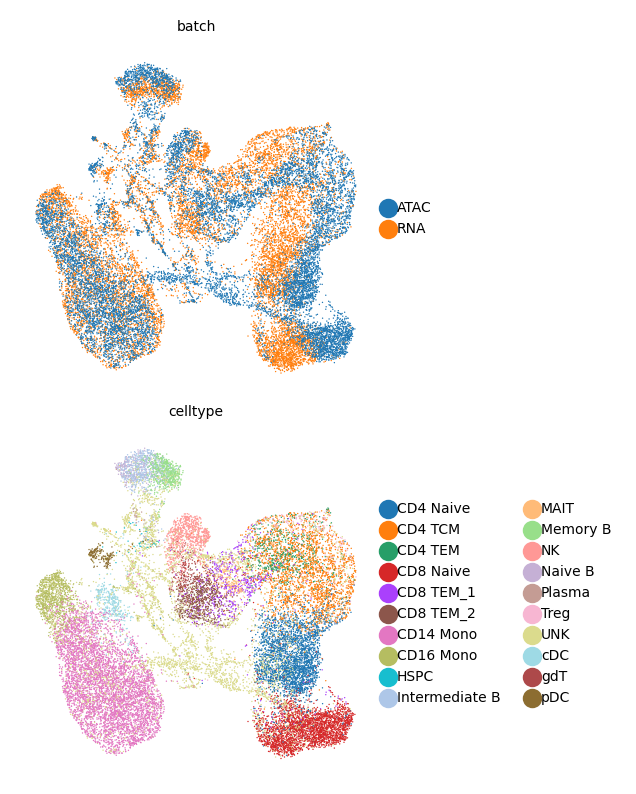

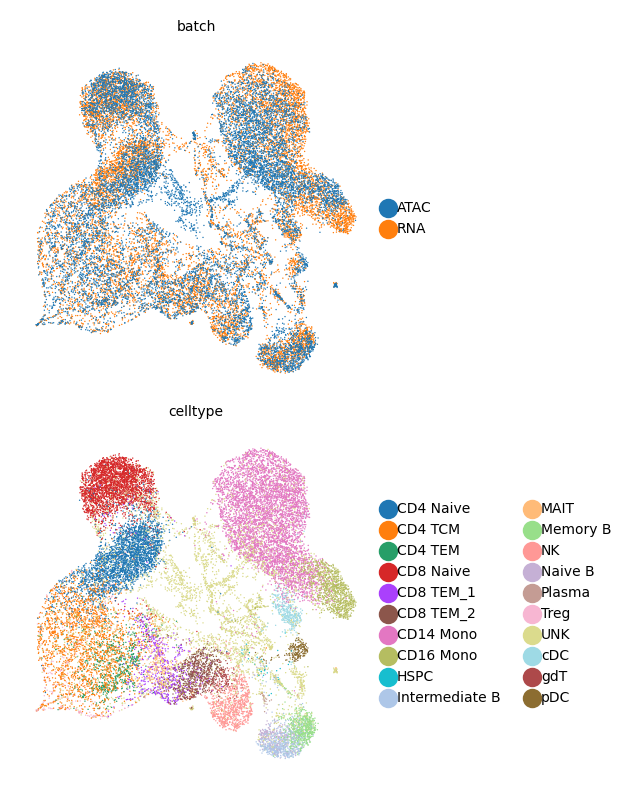

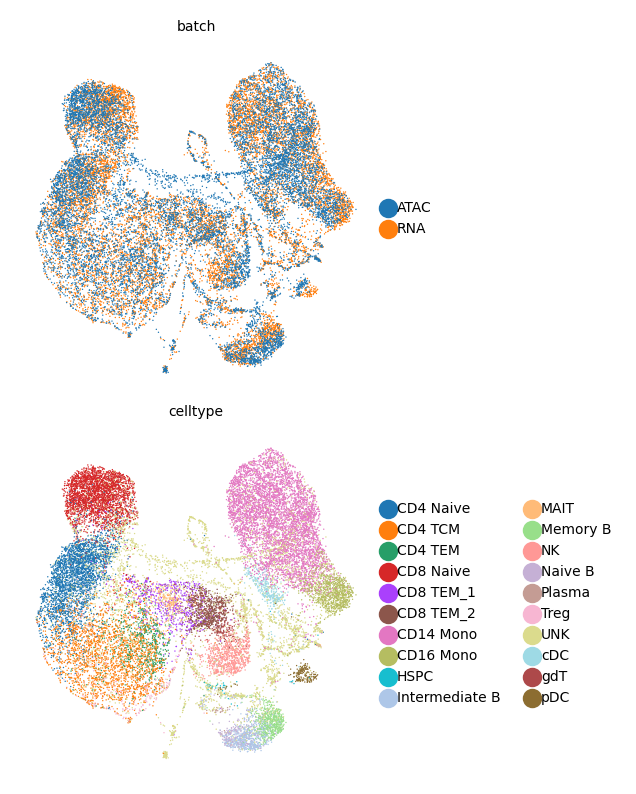

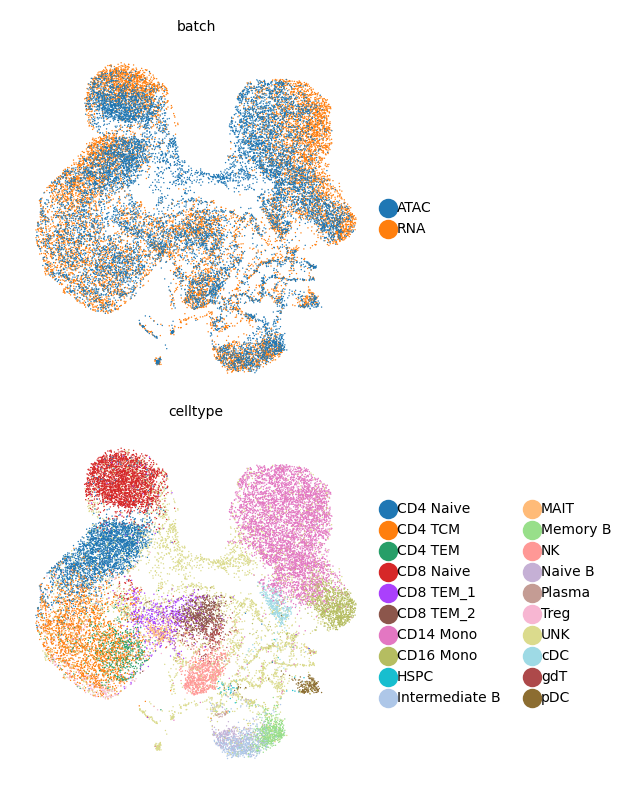

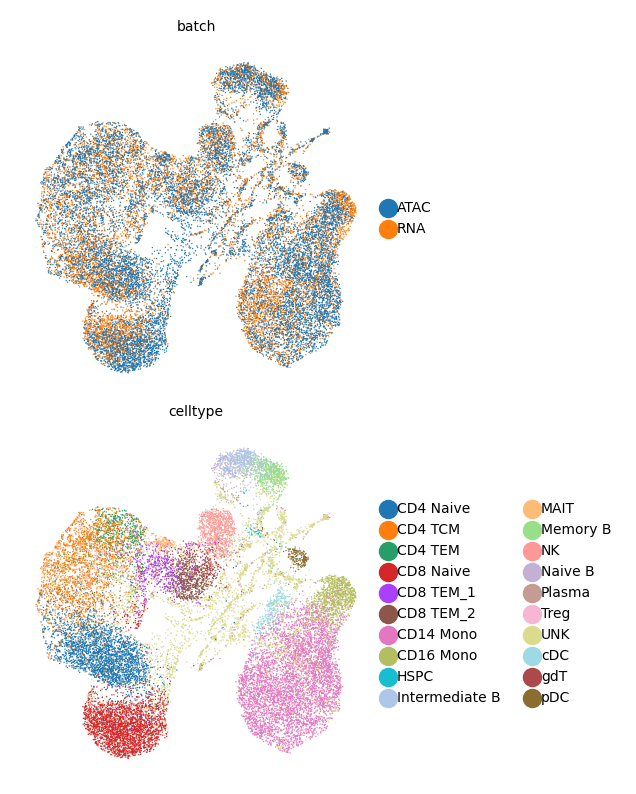

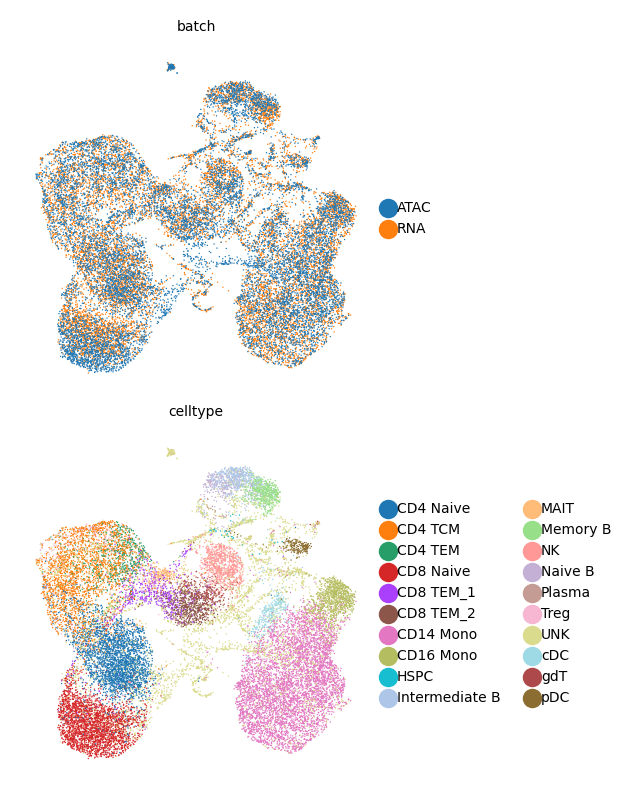

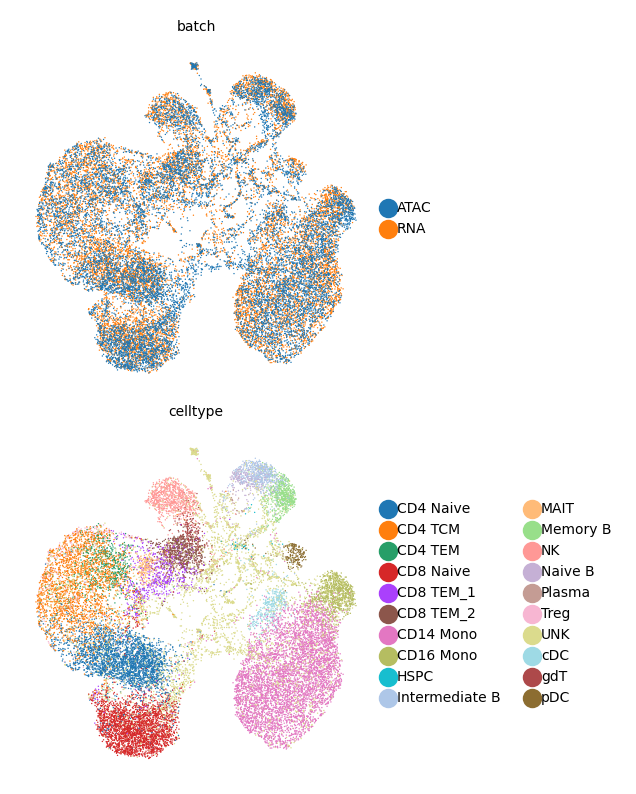

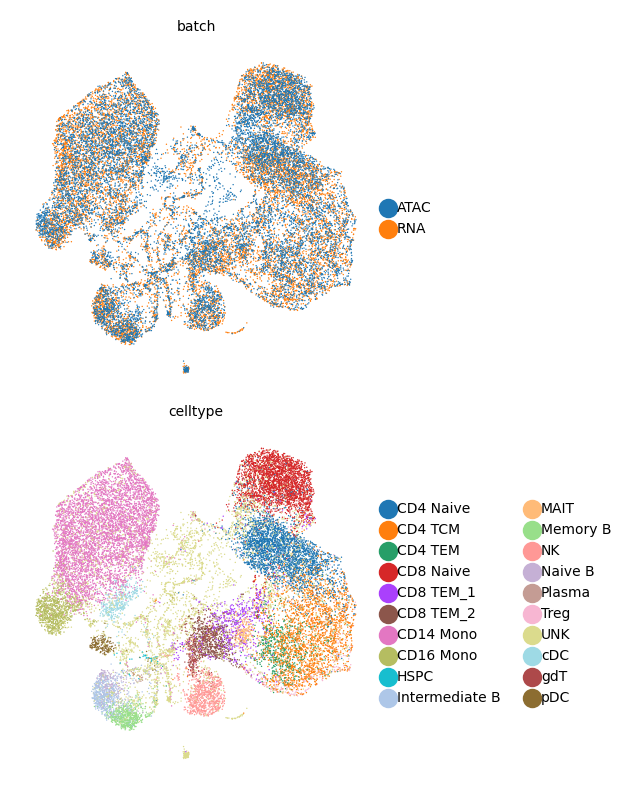

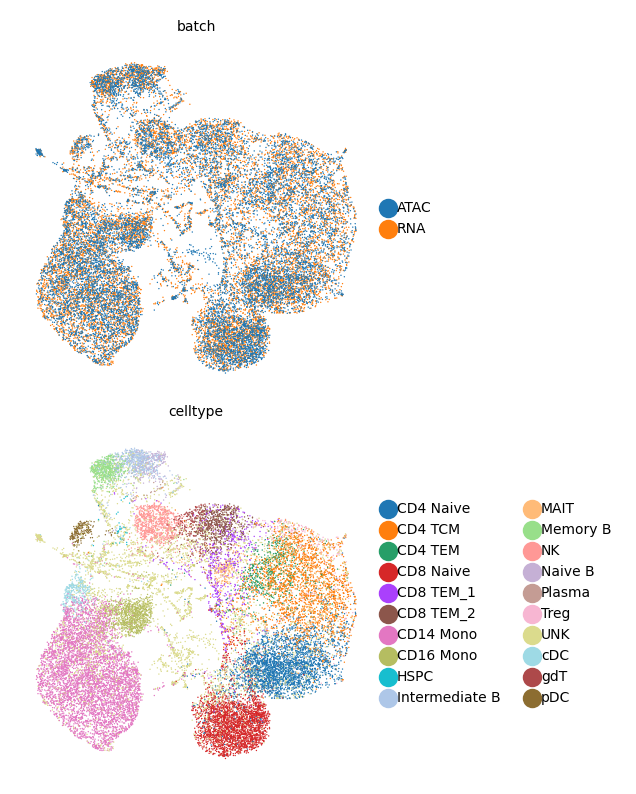

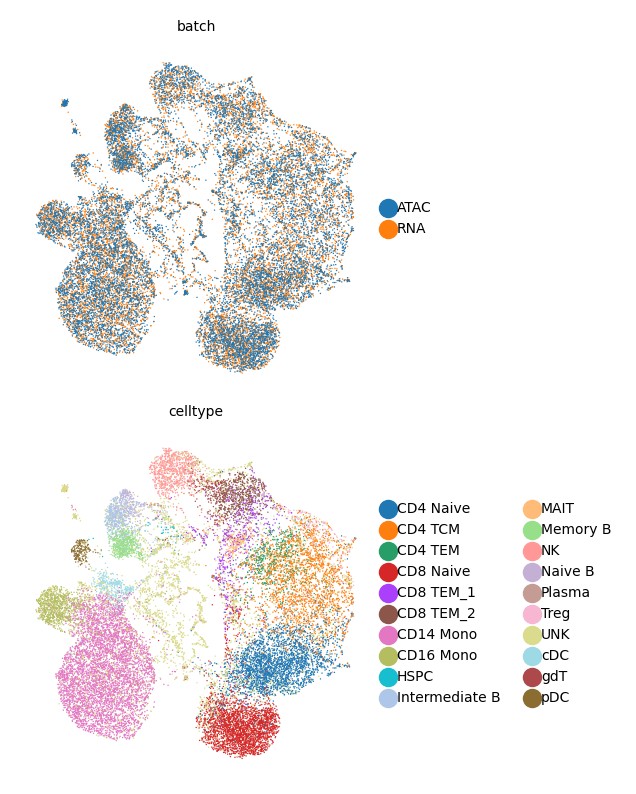

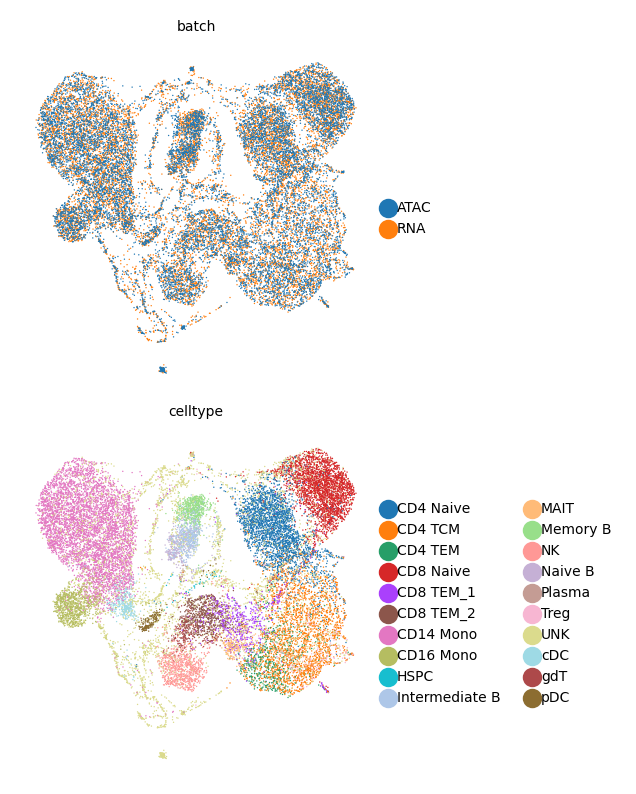

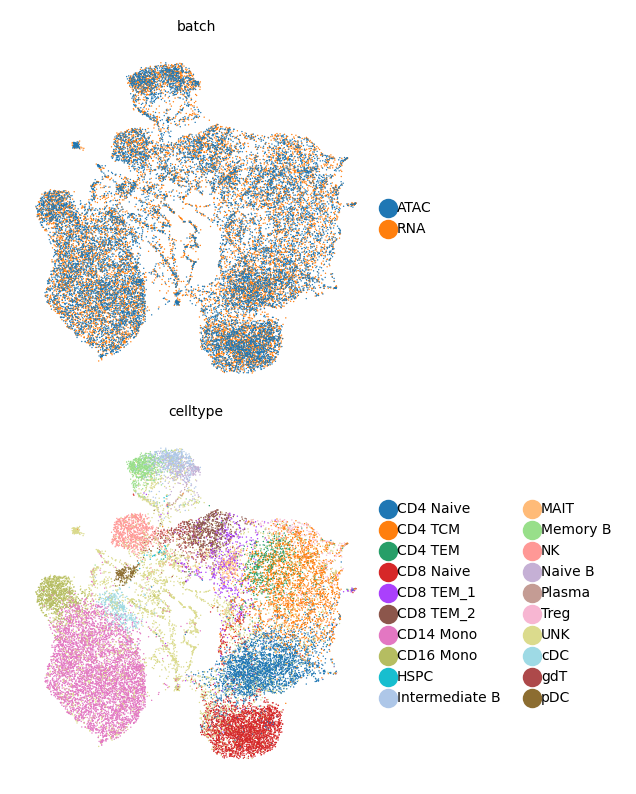

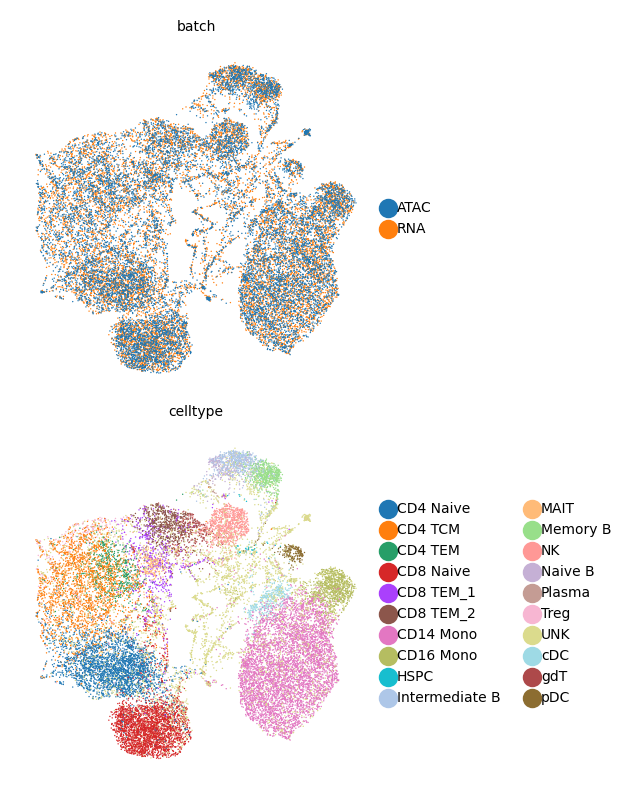

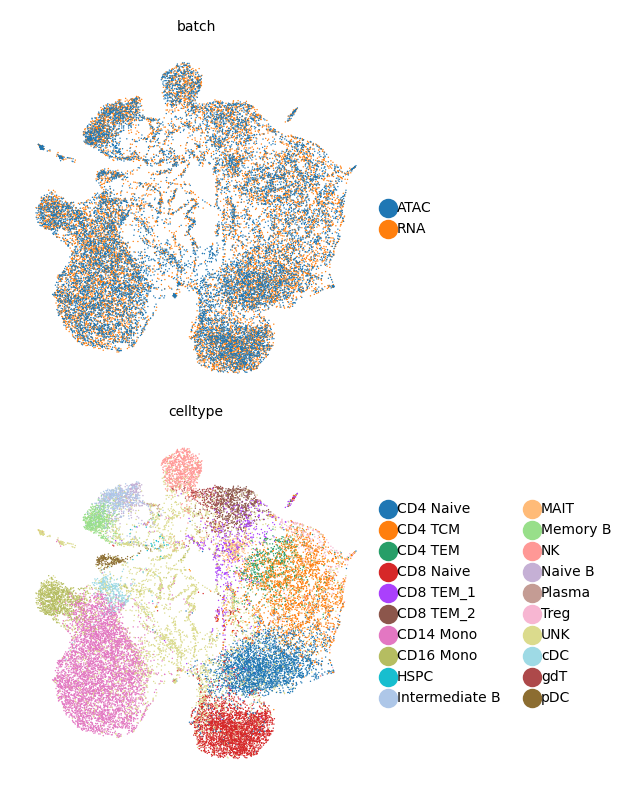

In [4]:
save_dif = f'./result/fig_umap/'
if not os.path.exists(save_dif):
    os.makedirs(save_dif)
for i in range(20):   
    ep = i+1
    f = np.load(f'./result/result_ep{ep}.npz')
    cell_embed_RNA = f['cell_embed_RNA']
    cell_embed_ATAC = f['cell_embed_ATAC']
    RNA_id = f['RNA_id']
    adata_rna_1 =adata_rna[RNA_id]
    adata_atac_1 =adata_atac[RNA_id]
    celltype_list = adata_rna_1.obs['celltype'].tolist()
    adata_embed_RNA = sc.AnnData(cell_embed_RNA)
    adata_embed_ATAC = sc.AnnData(cell_embed_ATAC)
    adata_embed_RNA.obs['celltype'] = celltype_list
    adata_embed_ATAC.obs['celltype'] = celltype_list
    adata_encoder = adata_embed_RNA.concatenate(adata_embed_ATAC)
    batch_list = []
    for j in adata_encoder.obs['batch'].tolist():
        if j == '0':
            batch_list.append('RNA')
        else:
            batch_list.append('ATAC')
    adata_encoder.obs['batch'] = batch_list

    sc.pp.neighbors(adata_encoder, use_rep='X')
    sc.tl.umap(adata_encoder)
    sc.settings.set_figure_params(dpi=200, facecolor='white',frameon=False,fontsize=5.5)
    plt.rcParams.update({
        'svg.fonttype':'none',
        "font.size":5.5,
        'axes.labelsize': 5.5,
        'axes.titlesize':5,
        'legend.fontsize': 5,
        'ytick.labelsize':5,
        'xtick.labelsize':5,
    })
    cm = 1/2.54
    fig, axes = plt.subplots(2, 1,figsize=(8*cm,10*cm))
    sc.pl.umap(adata_encoder, color=['batch'],show=False,ax=axes[0], size=1)
    sc.pl.umap(adata_encoder, color=['celltype'],show=False, ax=axes[1], size=1)
    fig.tight_layout()
    fig.savefig(save_dif + f'ep{ep}_umap.png')
    print('plot finished')

# Evaluation

In [5]:
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import Normalizer
from typing import Any, Mapping, Optional, TypeVar, Union
Array = Union[np.ndarray, scipy.sparse.spmatrix]

In [6]:
def tfidf(X: Array) -> Array:
    r"""
    TF-IDF normalization (following the Seurat v3 approach)

    Parameters
    ----------
    X
        Input matrix

    Returns
    -------
    X_tfidf
        TF-IDF normalized matrix
    """
    idf = X.shape[0] / X.sum(axis=0)
    if scipy.sparse.issparse(X):
        tf = X.multiply(1 / X.sum(axis=1))
        return tf.multiply(idf)
    else:
        tf = X / X.sum(axis=1, keepdims=True)
        return tf * idf

In [7]:
# X_pca 
X = adata_rna_1.X
u, s, vh = randomized_svd(X.T @ X, 20, n_iter=15, random_state=0)
adata_rna_1.obsm["X_pca"] = X @ vh.T

# X_LSI
X = tfidf(adata_atac_1.X)
X = Normalizer(norm="l1").fit_transform(X)
X = np.log1p(X * 1e4)
u, s, vh = randomized_svd(X, 20, n_iter=15, random_state=0)
X_lsi = X @ vh.T / s
X_lsi -= X_lsi.mean(axis=1, keepdims=True)
X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
adata_atac_1.obsm["X_lsi"] = X_lsi.astype(np.float32)
combined_uni = np.concatenate([adata_rna_1.obsm['X_pca'], adata_atac_1.obsm['X_lsi']])

In [8]:
dict_ = {}
dict_['epoch'] = []
dict_['map'] = []
dict_['asw'] = []
dict_['asw_batch'] = []
dict_['gc'] = []
dict_['nc'] = []
dict_['sas'] = []
dict_['foscttm'] = []
for i in range(20):   
    ep = i+1
    print('ep:',ep)
    f = np.load(f'./result/result_ep{ep}.npz')
    cell_embed_RNA = f['cell_embed_RNA']
    cell_embed_ATAC = f['cell_embed_ATAC']
    RNA_id = f['RNA_id']
    adata_rna_1 =adata_rna[RNA_id]
    adata_atac_1 =adata_atac[RNA_id]
    celltype_list = adata_rna_1.obs['celltype'].tolist()
    adata_embed_RNA = sc.AnnData(cell_embed_RNA)
    adata_embed_ATAC = sc.AnnData(cell_embed_ATAC)
    adata_embed_RNA.obs['celltype'] = celltype_list
    adata_embed_ATAC.obs['celltype'] = celltype_list
    adata_encoder = adata_embed_RNA.concatenate(adata_embed_ATAC)
    batch_list = []
    for j in adata_encoder.obs['batch'].tolist():
        if j == '0':
            batch_list.append('RNA')
        else:
            batch_list.append('ATAC')
    adata_encoder.obs['batch'] = batch_list
    map = mean_average_precision(adata_encoder.X,np.array(adata_encoder.obs['celltype']))
    asw = avg_silhouette_width(adata_encoder.X,np.array(adata_encoder.obs['celltype']))
    asw_batch = avg_silhouette_width_batch(adata_encoder.X,np.array(adata_encoder.obs['batch']),np.array(adata_encoder.obs['celltype']))
    gc = graph_connectivity(adata_encoder.X,np.array(adata_encoder.obs['celltype']))
    nc = neighbor_conservation(adata_encoder.X,combined_uni,np.array(adata_encoder.obs['batch']))
    sas = seurat_alignment_score(adata_encoder.X,np.array(adata_encoder.obs['batch']), random_state=0)
    foscttm_x, foscttm_y = foscttm(cell_embed_RNA,cell_embed_ATAC)
    foscttm_ = np.mean(np.concatenate([foscttm_x,foscttm_y]))
    dict_['epoch'].append(ep)
    dict_['map'].append(map)
    dict_['asw'].append(asw)
    dict_['asw_batch'].append(asw_batch)
    dict_['gc'].append(gc)
    dict_['nc'].append(nc)
    dict_['sas'].append(sas)
    dict_['foscttm'].append(foscttm_)

ep: 1
ep: 2
ep: 3
ep: 4
ep: 5
ep: 6
ep: 7
ep: 8
ep: 9
ep: 10
ep: 11
ep: 12
ep: 13
ep: 14
ep: 15
ep: 16
ep: 17
ep: 18
ep: 19
ep: 20


In [13]:
f1 = pd.DataFrame(dict_)
value_array = f1.values
value_array_1 = value_array[:,1:-1]

In [14]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
value_array_scaled_1 = min_max_scaler.fit_transform(value_array_1)

In [15]:
biology = []
mix = []
total_score = []
for i in range(len(value_array_scaled_1)):
    bio = np.mean([value_array_scaled_1[i,1],value_array_scaled_1[i,0],value_array_scaled_1[i,4]])
    biology.append(bio)
    m = np.mean([value_array_scaled_1[i,2],value_array_scaled_1[i,3],value_array_scaled_1[i,5]])
    mix.append(m)
    total_score.append(0.6*bio + 0.4*m)

In [16]:
f1['biology conservation'] = biology
f1['omics mixing'] = mix
f1['Overall integration score'] = total_score

In [17]:
f1

epoch       map       asw  asw_batch        gc        nc       sas  \
0       1  0.519369  0.468645   0.921829  0.827879  0.099392  0.564941   
1       2  0.628480  0.506337   0.926606  0.859825  0.142165  0.661209   
2       3  0.665588  0.536080   0.893995  0.893673  0.163456  0.692906   
3       4  0.684420  0.539085   0.899668  0.899921  0.178205  0.632163   
4       5  0.691706  0.548269   0.862424  0.891727  0.185479  0.629675   
5       6  0.687129  0.534258   0.888228  0.885607  0.184719  0.769678   
6       7  0.698656  0.542478   0.839711  0.899502  0.192575  0.593154   
7       8  0.690408  0.539550   0.926760  0.909988  0.189923  0.797904   
8       9  0.690617  0.531366   0.922222  0.923490  0.190884  0.843926   
9      10  0.703500  0.538029   0.924670  0.923345  0.193775  0.796606   
10     11  0.699249  0.535291   0.933132  0.933037  0.191274  0.860994   
11     12  0.695713  0.533718   0.947647  0.934399  0.188392  0.931023   
12     13  0.692158  0.534447   0.937849  0.931100  0.186267  0.907127   
13     14  0.689231  0.532644   0.949341  0.925597  0.184871  0.938793   
14     15  0.682134  0.530020   0.959045  0.933103  0.181511  0.974746   
15     16  0.674847  0.527114   0.967222  0.929039  0.180524  0.989870   
16     17  0.672741  0.526329   0.970898  0.929145  0.179599  0.994143   
17     18  0.672365  0.526121   0.970768  0.928667  0.179226  0.994211   
18     19  0.672285  0.525976   0.971090  0.928056  0.179120  0.994484   
19     20  0.679795  0.528491   0.967018  0.926771  0.180688  0.980760   

     foscttm  biology conservation  omics mixing  Overall integration score  
0   0.118922              0.000000      0.208351                   0.083340  
1   0.064403              0.506375      0.395141                   0.461881  
2   0.045499              0.773259      0.442923                   0.641125  
3   0.038502              0.872023      0.429729                   0.695105  
4   0.034361              0.949350      0.307661                   0.692674  
5   0.027424              0.879722      0.462625                   0.712883  
6   0.028911              0.962746      0.246021                   0.676056  
7   0.022406              0.926193      0.658586                   0.819150  
8   0.018449              0.895705      0.725038                   0.827438  
9   0.020068              0.957132      0.694076                   0.851910  
10  0.015445              0.929141      0.795840                   0.875820  
11  0.012368              0.905975      0.891274                   0.900095  
12  0.011879              0.895086      0.837546                   0.872070  
13  0.011069              0.877308      0.874059                   0.876009  
14  0.008382              0.841611      0.950066                   0.884993  
15  0.006959              0.812766      0.969834                   0.875593  
16  0.006830              0.802399      0.982807                   0.874563  
17  0.006904              0.799532      0.981034                   0.872133  
18  0.006779              0.798406      0.980151                   0.871104  
19  0.008209              0.828068      0.955151                   0.878901

In [18]:
f1.to_csv('./result/metrics.csv')